In [1]:
import numpy as np
import theano
import theano.tensor as T
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

import os 
import timeit

% matplotlib inline
plt.rcParams['figure.figsize'] = (15.0, 10.0) # set default size of plots

In [2]:
def load_data(dataset = 'gibbs-sample.dat.npy', borrow = True):
    """
    Loads the dataset.
    """
    data = np.load(dataset)
    dataset = theano.shared(np.asarray(data, dtype = theano.config.floatX), borrow = borrow)
        
    return dataset   

In [13]:
class mpf(object):
    """
    Minimum probability flow
    """
    
    def __init__(self, input = None, n = 16, W = None, b = None):
        """
        Initialize mpf class
        """
        self.n = n
        
        U = np.random.rand(self.n, self.n)
        R = 0.5 * (U + U.T)
        np.fill_diagonal(R, 0)
        
        if not W:
            initial_W = np.asarray(R, dtype = theano.config.floatX)
            W = theano.shared(initial_W, name = 'W', borrow = True)
        
        if not b:
            initial_b = np.asarray(np.zeros(n), dtype = theano.config.floatX)
            b = theano.shared(initial_b, name = 'b', borrow = True)
            
            
        self.W = W
        self.b = b
#         self.input = input
        if input is None:
            self.x = T.dmatrix(name = 'input')
        else:
            self.x = input
        
        self.params = [self.W, self.b]
    
    
    def Kcost(self, learning_rate = 0.01):
        """
        Returns the cost
        """
        
        cost = T.mean(T.exp((0.5 - self.x) * (T.dot(self.x, self.W) + self.b))) 
#         gparams = T.grad(cost, self.params)
#         updates = [(param, param - learning_rate * gparam) for param, gparam in zip(self.params, gparams)]
        Wgrad = T.grad(cost, self.W)
#         T.fill_diagonal(Wgrad, 0)
        bgrad = T.grad(cost, self.b)
        
        Wupdate = T.fill_diagonal(0.5 * ((self.W - learning_rate * Wgrad) + (self.W - learning_rate * Wgrad).T), 0)
        updates = [(self.W, Wupdate), (self.b, self.b - learning_rate * bgrad )]
#         updates = [(self.W, self.W - learning_rate * Wgrad), (self.b, self.b - learning_rate * bgrad )]
        
        return cost, updates
            
                

In [14]:
def sgd(learning_rate = 0.01, n_epochs = 1000, dataset = 'gibbs-sample.dat.npy', batch_size = 10):
    """
    Perform stochastic gradient descent on MPF
    """
    print ('Loading '+dataset+'...')
    
    dataset = load_data(dataset)
    
    n_dataset_batches = dataset.get_value(borrow = True).shape[0] // batch_size
    
    print ('Building the model...')

    index = T.lscalar()
    x = T.matrix('x')
    
#     if not os.path.isdir(output_folder):
#         os.makedirs(output_folder)
#     os.chdir(output_folder)   
    
    flow = mpf(input = x)
    cost, updates = flow.Kcost()
    
    train_mpf = theano.function(inputs = [index], outputs = cost, updates = updates, \
                                givens = {x: dataset[index * batch_size: (index + 1) * batch_size]})
    
    start_time = timeit.default_timer()
    
    for epoch in range(n_epochs):
        c = []
        for batch_index in range(n_dataset_batches):
            c.append(train_mpf(batch_index))

#         print ('Training epoch %d, cost' % epoch, np.mean(c, dtype='float64'))
        
    end_time = timeit.default_timer()
    
    training_time = end_time - start_time
    
    print ('The training took %.2f minutes' % (training_time/60.))
    
    W_learnt = flow.W.get_value(borrow = True)
    b_learnt = flow.b.get_value(borrow = True)
    W = np.load('W.dat.npy')
    
    print ('Plotting the matrics...')
    plt.plot(W.reshape(-1,1)[0:100])
    plt.plot(W_learnt.reshape(-1,1)[0:100],'r')
    
    return W_learnt, b_learnt

Loading gibbs-sample.dat.npy...
Building the model...
The training took 4.46 minutes
Plotting the matrics...


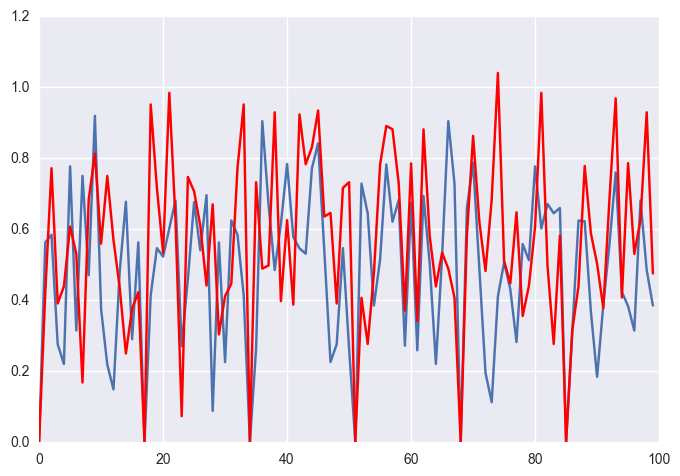

In [15]:
W_learnt, b_learnt = sgd()

In [ ]:
W = np.load('W.dat.npy')

In [ ]:
plt.plot(W.reshape(-1,1)[100:200])
plt.plot(W_learnt.reshape(-1,1)[100:200],'r')

In [ ]:
plt.plot(W.reshape(-1,1)[200:255])
plt.plot(W_learnt.reshape(-1,1)[200:255],'r')

Loading DataSync51.dat.npy...
Building the model...
The training took 4.99 minutes
Plotting the matrics...


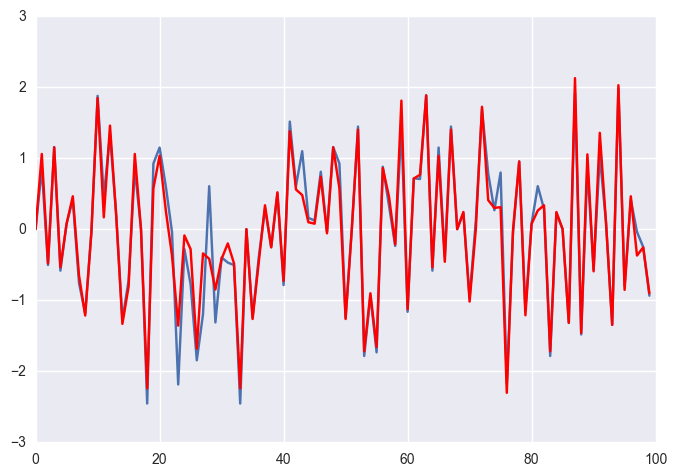

In [10]:
run lmpf.py

Loading gibbs-sample.dat.npy...
Building the model...
The training took 4.53 minutes
Plotting the matrics...


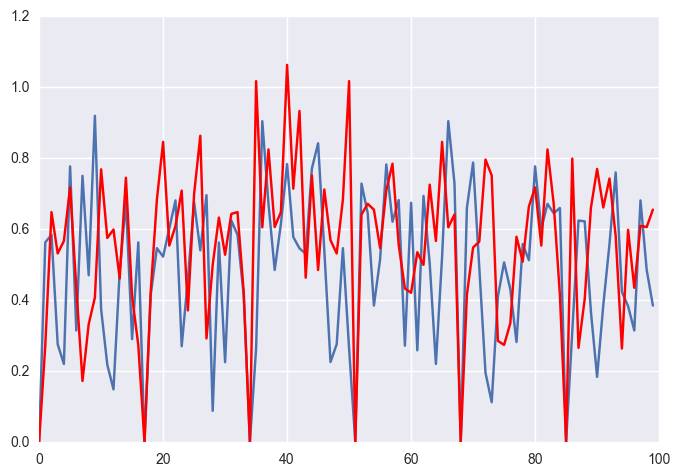

In [12]:
run lmpf.py